# Chapter 14: Training A Transformer to Predict Image Tokens

This chapter covers

* Buliding a Transformer to predict image tokens
* Preparing data to train a Transformer to predict image tokens
* Generating images by predicting image tokens with a trained Transformer
* Image generation with a pretrained Transformer based on image segmentation  

In this chapter, you'll learn how to to generate images as in the 2021 paper Taming Transformers for High-Resolution Image Synthesis (https://arxiv.org/abs/2012.09841). Specifically, we treat an image as a sequence of image patches. We'll then train a Transformer to learn long-range interactions among different image patches in the sequence, just as a Transformer learns the long-range dependencies among different words in a sentence. 

In contrast to convolutional neural networks (CNNs), image Transformers contain no inductive bias that prioritizes local interactions. This makes iamge Transformers expressive, but also computationally costly for long sequences (e.g., high-resolution images that contain many image patches). The model uses CNNs to learn a context-rich vocabulary of image constituents. At the same time, the model uses Transformers to efficiently capture their composition within high-resolution images. 

# 1.    Create A Transformer Model
In 2021, Esser et al proposed a generative model, Vector Quantized Generative Adversarial Networks (VQGAN; https://arxiv.org/pdf/2012.09841.pdf). The model utilizes both convolutional neural networks and a Transformer. The model consists of two stages. In the first stage, the model learns to encode images into a low-dimensional latent space. It then applies vector quantization to use a codebook of discrete vectors to represent the distribution in the latent space. The quantized latent vectors are then projected back to the original image space using the decoder part of the model. In the second stage, an image is divided into a sequence of codebook vectors. A Transformer is trained to learn which codebook vector is the most likely choice based on previous codebook vectors in the image. 

In this chapter, you'll learn how to create a VQGAN and train it to reconstruct an image. We'll construct and train the Transformer in the next chapter. 

The Python programs in this chapter and the next are adapted from GitHub repositories by Dominic Rampas (https://github.com/dome272/VQGAN-pytorch) and the Computer Vision and Learning research group at Ludwig Maximilian University of Munich (https://github.com/CompVis/taming-transformers).

The VQGAN has a generator and a discriminator. The generator itself has an autoencoder structure, meaning it consists of an encoder and a decoder, similar to a variational autoencoder (VAE). However, VAE assumes a normal distribution in the latent space. Instead, in VQGAN, we'll use a codebook of discrete vectors to approximate the latent space. 

In this section, you'll learn to construct various parts of the VQGAN: the discriminator, the encoder, the decoder, and the codebook. 

## 1.1 Freeze the VQGAN Model
The VQGAN model you trained in the last chapter will be used in the Transformer model in this chapter.

We first create a VQGAN model and load the trained weights, as follows:

In [1]:
class Config:
    latent_dim=256
    image_size=256
    num_codebook_vectors=1024
    beta=0.25
    image_channels=3
    dataset_path=r"E:\ManningStuff\CLIPtrain\files\Images"
    checkpoint_path='files/vqgan_epoch_1.pt'
    device="cuda"
    batch_size=8
    epochs=10
    learning_rate=2.25e-05
    beta1=0.5
    beta2=0.9
    disc_start=10000
    disc_factor=1.
    l2_loss_factor=1.
    perceptual_loss_factor=1.
    pkeep=0.5
    sos_token=0
config=Config()

# initiate VQGAN
from utils.VQGANutil import VQGAN
vqgan=VQGAN(config).to(config.device)
vqgan.load_checkpoint(config.checkpoint_path)
vqgan.eval()

We'll use the trained VQGAN to encode an image into the latent space. In particular, we'll obtain the quantized latent vectors, as well as the indexes of the vectors used to represent each of the 256 patches in the images. For that purpose, we define the following encode_to_z() function:

In [2]:
def encode_to_z(x):
    quant_z, indices, _ = vqgan.encode(x)
    indices = indices.view(quant_z.shape[0], -1)
    return quant_z, indices

The Transformer treats an image as a sequence of patches. Each patch is represented by one of the 1024 discrete latent vectors (let's call them image tokens). The Transformer's job is to predict the next image token based on all previous image tokens in the sequence.

Once the Transformer finishes predicting all 256 image tokens, we need to convert those image tokens back into an image. Therefore, we use the trained VQGAN to define a z_to_imge() function like this:

In [3]:
def z_to_image(indices, p1=16, p2=16):
    ix_to_vectors = vqgan.codebook.embedding(indices).reshape(\
                              indices.shape[0], p1, p2, 256)
    ix_to_vectors = ix_to_vectors.permute(0, 3, 1, 2)
    image = vqgan.decode(ix_to_vectors)
    return image  

## 1.2 Build A Transformer
The main component of the Transformer is a generative pretrained Transformer (GPT), which is borrowed from Andrej Kaparthy's GitHub repository https://github.com/karpathy/minGPT/. 

Download the file mingpt.py from the book's GitHub repository and place it in the /utils/ folder on your computer. 

We define a Transformer model as follows:

In [4]:
from torch import nn
import torch
from utils.mingpt import GPT

class VQGANTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        transformer_config = {
            "vocab_size": config.num_codebook_vectors,
            "block_size": 512,
            "n_layer": 24,
            "n_head": 16,
            "n_embd": 1024}
        self.transformer = GPT(**transformer_config)
        
    def forward(self, x):
        _, indices = encode_to_z(x)
        sos_tokens = torch.ones(x.shape[0], 1) * config.sos_token
        sos_tokens = sos_tokens.long().to("cuda")
        mask = torch.bernoulli(config.pkeep * torch.ones(indices.shape,
                                             device=indices.device))
        mask = mask.round().to(dtype=torch.int64)
        random_indices = torch.randint_like(indices, 
                                self.transformer.config.vocab_size)
        new_indices = mask * indices + (1 - mask) * random_indices
        new_indices = torch.cat((sos_tokens, new_indices), dim=1)
        target = indices
        logits, _ = self.transformer(new_indices[:, :-1])
        return logits, target

    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float("inf")
        return out
model = VQGANTransformer(config).to(config.device)    

We'll train the Transformer next

# 2.	Prepare for the Training of the Transformer
To train the Transformer, you'll load the training data and process them for training as you did in the previous chapter. We'll train the model for only two epochs. In each epochs, we'll use only two batches of data just to show how the training works. Later in the chapter, you'll use a pretrained VQGAN Transformer model to predict image tokens and create new images.

## 2.1	Precess the Training Data
As we did in the last chapter, we first define a Data() class as follows:

In [5]:
import os
import albumentations
import numpy as np
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class Data(Dataset):
    def __init__(self, config):
        self.imgs=[os.path.join(config.dataset_path,f) for f 
                   in os.listdir(config.dataset_path)]
        self.rescaler=albumentations.SmallestMaxSize(max_size=config.image_size)
        self.cropper=albumentations.CenterCrop(height=config.image_size,
                                               width=config.image_size)
        self.preprocessor=albumentations.Compose([self.rescaler, self.cropper])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, i):
        image = Image.open(self.imgs[i])
        if not image.mode == "RGB":
            image = image.convert("RGB")
        image = np.array(image).astype(np.uint8)
        image = self.preprocessor(image=image)["image"]
        image = (image / 127.5 - 1.0).astype(np.float32)
        image = image.transpose(2, 0, 1)
        return image       

We then call the Data() class to process all images in the Flickr 8k dataset, like so:

In [6]:
trainset=Data(config)

Next, we place the training data in batches. The batch size is set at 8. 

In [7]:
trainloader=DataLoader(trainset,batch_size=config.batch_size,
                       shuffle=True)

## 2.2	Configurate the Optimizer
We'll use the AdamW optimizer, a variant of the Adam optimizer that we have been using throughout this book. The AdamW optimizer, first proposed by Ilya Loshchilov and Frank Hutter, decouples weight decay (a form of regularization) from the optimization steps. Instead of applying weight decay directly to the gradients, AdamW applies weight decay directly to the parameters (weights) after the optimization step. This modification helps achieve better generalization performance by preventing the decay rate from being adapted along with the learning rates. 

Weight decay in the context of the AdamW optimizer is a technique used to regularize the training of deep learning models by adding a penalty to the loss function based on the magnitude of the weights. Unlike traditional L2 regularization, where the weight penalty is applied before the optimizer updates the model parameters, AdamW applies weight decay directly to the weights themselves during the optimization step. This approach decouples the weight decay from the learning rate, potentially leading to more effective regularization and improving convergence in training deep learning models.

We'll apply weight decay to only the weights in linear layers in the Transformer model. Therefore, we define the following configure_optimizers() function:

In [8]:

def configure_optimizers():
    decay, no_decay = set(), set()
    whitelist_weight_modules = (nn.Linear, )
    blacklist_weight_modules = (nn.LayerNorm, nn.Embedding)

    for mn, m in model.transformer.named_modules():
        for pn, p in m.named_parameters():
            fpn = f"{mn}.{pn}" if mn else pn
            if pn.endswith("bias"):
                no_decay.add(fpn)
            elif pn.endswith("weight") and isinstance(m, 
                                  whitelist_weight_modules):
                decay.add(fpn)
            elif pn.endswith("weight") and isinstance(m, 
                                  blacklist_weight_modules):
                no_decay.add(fpn)
    no_decay.add("pos_emb")
    param_dict = {pn: p for pn, p in 
                  model.transformer.named_parameters()}
    optim_groups = [
    {"params": [param_dict[pn] for pn in sorted(list(decay))],
     "weight_decay": 0.01},
    {"params": [param_dict[pn] for pn in 
                sorted(list(no_decay))], "weight_decay": 0.0},
    ]
    optimizer = torch.optim.AdamW(optim_groups, lr=4.5e-06,
                                  betas=(0.9, 0.95))
    return optimizer
optim=configure_optimizers()

## 2.3	A Few Helper Functions
We'll define a few helper functions so that we can see the progress of the model throughout training.

The first function, sample(), predicts the next image token based on previous image tokens in the sequence:

In [9]:
import torch.nn.functional as F

def sample(model, x, c, steps, temperature=1.0, top_k=100):
    model.transformer.eval()
    x = torch.cat((c, x), dim=1)
    for k in range(steps):
        logits, _ = model.transformer(x)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            logits = model.top_k_logits(logits, top_k)
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1)
        x = torch.cat((x, ix), dim=1)
    x = x[:, c.shape[1]:]
    model.transformer.train()
    return x

We also define a log_images() function to record an original image, the recontructed image by VQGAN, a quarter sample and a half sample. 

In [10]:
def log_images(model, x):
    log = dict()
    _, indices = encode_to_z(x)
    sos_tokens = torch.ones(x.shape[0], 1) * config.sos_token
    sos_tokens = sos_tokens.long().to("cuda")
    start_indices = indices[:, :indices.shape[1] // 2]
    sample_indices = sample(model, start_indices, sos_tokens, 
        steps=indices.shape[1] - start_indices.shape[1])
    half_sample = z_to_image(sample_indices)
    start_indices = indices[:, :indices.shape[1] // 4]
    sample_indices = sample(model, start_indices, sos_tokens, 
        steps=indices.shape[1] - start_indices.shape[1])
    quarter_sample = z_to_image(sample_indices)
    x_rec = z_to_image(indices)
    log["input"] = x/2+0.5
    log["rec"] = x_rec/2+0.5
    log["quarter_sample"] = quarter_sample/2+0.5    
    log["half_sample"] = half_sample/2+0.5
    return log, torch.concat((x, x_rec, 
          quarter_sample, half_sample))/2+0.5

Finally, we'll periodically plot the sampled images and compare them wit the original and reconstructed images. For that purpose, we define the following plot_images() function:

In [11]:
def plot_images(images):
    x = images["input"]
    reconstruction = images["rec"]
    half_sample = images["half_sample"]
    quarter_sample = images["quarter_sample"]
    fig, axarr = plt.subplots(1, 4, dpi=200)
    axarr[0].imshow(x.cpu().detach().numpy()[0].transpose(1,2,0))
    axarr[0].axis("off")
    axarr[1].imshow(reconstruction.cpu().detach(
        ).numpy()[0].transpose(1,2,0))
    axarr[1].axis("off")
    axarr[2].imshow(quarter_sample.cpu().detach(
        ).numpy()[0].transpose(1,2,0))
    axarr[2].axis("off")
    axarr[3].imshow(half_sample.cpu().detach(
        ).numpy()[0].transpose(1,2,0))
    axarr[3].axis("off")
    plt.show()

# 3	Train and Use the Transformer to Predict Image Tokens 
In this section, we'll first train the Transformer using images in the Flickr 8k dataset. We basically divide images into 16x16 grids. Therefore, each image has 256 patches and each patch is represented by a discrete vector in the code book in the trained VQGAN. We then convert an image into a sequence of indexes (image tokens). We then train the Transformer to predict the next image token based on previous tokens in the sequence. 

After that, we'll use the trained Transformer to create new images. We'll use a quarter or a half of the image tokens as prompts and ask the trained Transformer to predict the rest of the image tokens. 

## 3.1 Train the Transformer to Predict Image Tokens
Training the Transformer is extremely time consuming, even with GPU training. Therefore, we'll train the model for only two epochs and use only two batches of training data in each epoch. 

  0%|                                                           | 1/1012 [00:02<50:05,  2.97s/it, Transformer_Loss=3.9]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


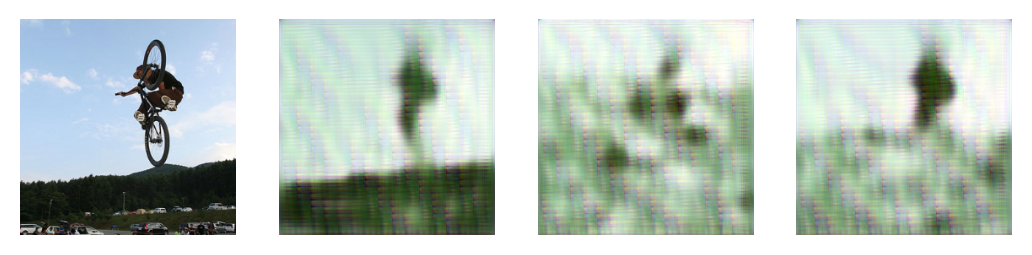

  0%|                                                          | 1/1012 [00:03<55:17,  3.28s/it, Transformer_Loss=2.65]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


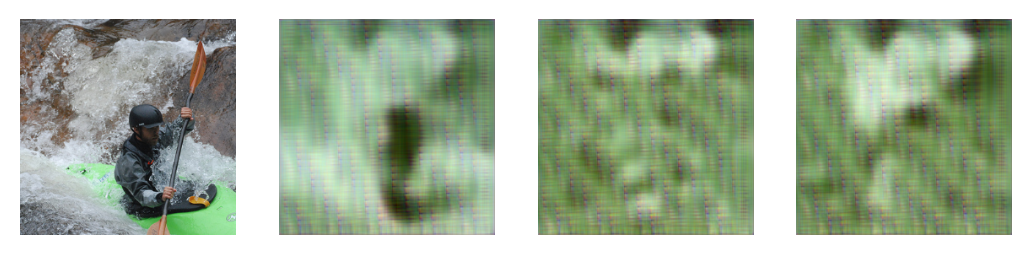

In [12]:
from tqdm import tqdm
from torchvision import utils as vutils

# train for two epochs
for epoch in range(2):
    with tqdm(range(len(trainloader))) as pbar:
        for i, imgs in zip(pbar, trainloader):
            optim.zero_grad()
            imgs = imgs.to(config.device)
            logits, targets = model(imgs)
            loss = F.cross_entropy(logits.reshape(-1, 
              logits.size(-1)),targets.reshape(-1))
            loss.backward()
            optim.step()
            pbar.set_postfix(Transformer_Loss=\
            np.round(loss.cpu().detach().numpy().item(), 4))
            pbar.update(0)
            # stop training the epoch after two batches
            if i>=1: break
    log, sampled_imgs = log_images(model, imgs[0][None])
    vutils.save_image(sampled_imgs, 
          f"files/transformer_{epoch}.jpg", nrow=4)
    plot_images(log)
    torch.save(model.state_dict(), 
               f"files/transformer_{epoch}.pt")

## 3.2 How to Use the Trained Transformer to Predict Image Tokens
To use the trained Transformer, we first load the trained weights:

In [13]:
sd=torch.load("files/transformer_1.pt")
model.load_state_dict(sd)

<All keys matched successfully>

We can select five images from the training data as our testing samples:

In [14]:
test=[]
for i in range(5):
    test.append(torch.Tensor(trainset[20+i]).unsqueeze(0))
imgs=torch.cat(test)

We feed the images to the trained VQGAN to obtain the indexes associated with the 1024 discrete latent vectors:

In [15]:
quant_z, indices, _ = vqgan.encode(imgs.to(config.device))
indices = indices.view(quant_z.shape[0], -1)
print(indices)

tensor([[648, 648, 648,  ..., 648, 648, 559],
        [648, 648, 648,  ..., 648, 648, 648],
        [648, 648, 648,  ..., 559, 559, 559],
        [559, 559, 559,  ..., 559, 648, 559],
        [559, 648, 648,  ..., 559, 559, 408]], device='cuda:0')


The image is now represented by 256 indexes, as a sequence. We'll insert the <SOS> token to the beginning of the sequence to signal the start of the sequence, as follows:

In [16]:
sos_tokens = torch.ones(imgs.shape[0], 1) * config.sos_token
sos_tokens = sos_tokens.long().to("cuda")

We use the first 128 image tokens as the prompt and feed it to the Transformer to let the Transformer to predict the remaining 128 image tokens:

In [17]:
start_indices = indices[:, :indices.shape[1] // 2]
sample_indices = sample(model, start_indices, sos_tokens,
          steps=indices.shape[1] - start_indices.shape[1])

We then use the trained VQGAN to convert the indexes back to images:

In [18]:
half_sample = z_to_image(sample_indices)

We can visualize the predicted images and compare them to the originals, as follows:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1291.5, 517.5, -0.5)

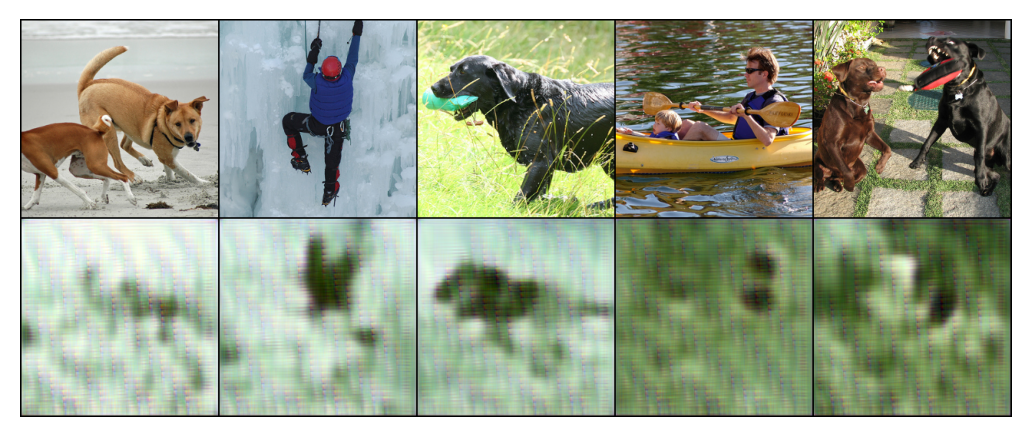

In [19]:
real_fake_images = torch.cat((imgs.to(config.device), 
              half_sample)).add(1).mul(0.5)
grid_img=vutils.make_grid(real_fake_images,nrow=5)
plt.figure(dpi=200)
plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()

The predicted images are of low quality. This is because we trained our VQGAN and Transformer for a limited number of epochs due to lack of supercomputing facilities. 

In the next section, we'll use pretrained VQGAN and Transformer to see how they can produce high-resolution images. 

# 4 Image Generation with Pretrained VQGAN and Transformer
We'll use pretrained VQGAN and Transformer based on the GitHub repository https://github.com/CompVis/taming-transformers. You'll first learn to reconstruct an image based on image segmentation. After that, you'll learn to generate images in Flickr 8k by predicting image tokens using the pretrained Transformer. 


## 4.1 Reconstruct An Image Based on Image Segmentation
The example in this section is based on this colab https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/taming-transformers.ipynb.

First, let's download the pretrained weights for the Transformer and the model specifications, like so:

In [20]:
# download files; you may need to change folder names
import requests, os

url1='https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' 
url2='https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1'

f1=r'E:\ManningStuff\GAI\VQGAN\VQGAN-CLIP\taming-transformers\2020-11-09T13-31-51-project.ckpt'
f2=r'E:\ManningStuff\GAI\VQGAN\VQGAN-CLIP\taming-transformers\2020-11-09T13-31-51-project.yaml'

# takes about 15min depending on your internet speed
if not os.path.exists(f1):
    fb1=requests.get(url1)
    with open(f1,"wb") as f:
        f.write(fb1.content)

if not os.path.exists(f2):
    fb2=requests.get(url2)
    with open(f2,"wb") as f:
        f.write(fb2.content)

We can now import the Transformer model from the GitHub repository https://github.com/CompVis/taming-transformers:

In [21]:
import sys
sys.path.append("./taming-transformers")

from omegaconf import OmegaConf

config = OmegaConf.load(f2)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))


from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)

import torch

sd = torch.load(f1, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)

model.cuda().eval()
torch.set_grad_enabled(False)

data:
  params:
    batch_size: 1
    validation:
      target: taming.data.sflckr.Examples
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 182
          num_res_blocks: 2
          out_ch: 182
          resolution: 256
          z_channels: 256
        embed_dim: 256
        image_key: segmentation
        lossconfig:
          target: taming.modules.losses.DummyLoss
        n_embed: 1024
      target: taming.models.vqgan.VQModel
    cond_stage_key: segmentation
    first_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          doub

We use a segmentation image as the guide to the Transformer so it knows what type of image to generate. The segmentation image comes with the cloning of the GitHub repository https://github.com/CompVis/taming-transformers:.

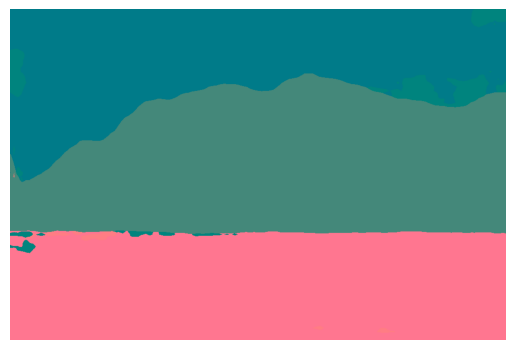

In [22]:
from PIL import Image
import numpy as np

device="cuda" if torch.cuda.is_available() else "cpu"
segmentation_path = "taming-transformers/data/sflckr_segmentations/norway/25735082181_999927fe5a_b.png"
segmentation = Image.open(segmentation_path)
segmentation = np.array(segmentation)
segmentation = np.eye(182)[segmentation]
segmentation = torch.tensor(
    segmentation.transpose(2,0,1)[None]).to(dtype=torch.float32, 
                                            device=device)

import matplotlib.pyplot as plt
def show_segmentation(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0,:,:,None,:]
  colorize = np.random.RandomState(1).randn(1,1,s.shape[-1],3)
  colorize = colorize / colorize.sum(axis=2, keepdims=True)
  s = s@colorize
  s = s[...,0,:]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  plt.imshow(s)
  plt.axis("off")
  plt.show()

show_segmentation(segmentation)

We'll feed the segmentation image to the trained model to obtain codebook indexes:

c_code torch.Size([1, 256, 42, 64]) torch.float32
c_indices torch.Size([2688]) torch.int64


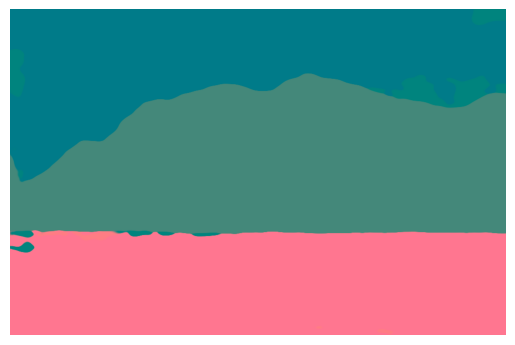

In [23]:
c_code, c_indices = model.encode_to_c(segmentation)
print("c_code", c_code.shape, c_code.dtype)
print("c_indices", c_indices.shape, c_indices.dtype)
assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[0]
segmentation_rec = model.cond_stage_model.decode(c_code)
show_segmentation(torch.softmax(segmentation_rec, dim=1))

To create an image based on image segmentation, we first randomly populate each patch with an index value. The index value refers to which discrete vector to use in the codebook. 

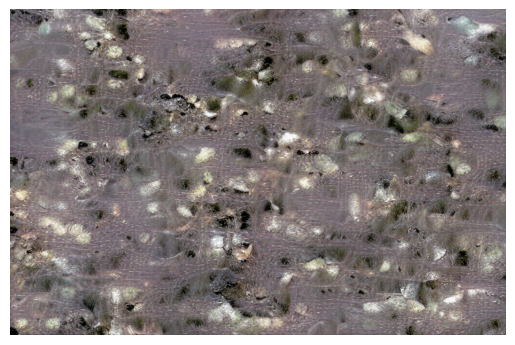

In [24]:
def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  plt.imshow(s)
  plt.axis("off")
  plt.show()

codebook_size = config.model.params.first_stage_config.params.embed_dim
z_indices_shape = c_indices.shape
z_code_shape = c_code.shape
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
x_sample = model.decode_to_img(z_indices, z_code_shape)
show_image(x_sample)

As you can see, the image shows random patterns. Next, we'll generate an image using the trained Transformer based on the segmentation image:

In [25]:
from IPython.display import clear_output
import time

idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

cidx = c_indices
cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

temperature = 1.0
top_k = 100
update_every = 50

start_t = time.time()
for i in range(0, z_code_shape[2]-0):
  if i <= 8:
    local_i = i
  elif z_code_shape[2]-i < 8:
    local_i = 16-(z_code_shape[2]-i)
  else:
    local_i = 8
  for j in range(0,z_code_shape[3]-0):
    if j <= 8:
      local_j = j
    elif z_code_shape[3]-j < 8:
      local_j = 16-(z_code_shape[3]-j)
    else:
      local_j = 8

    i_start = i-local_i
    i_end = i_start+16
    j_start = j-local_j
    j_end = j_start+16
    
    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    cpatch = cidx[:, i_start:i_end, j_start:j_end]
    cpatch = cpatch.reshape(cpatch.shape[0], -1)
    patch = torch.cat((cpatch, patch), dim=1)
    logits,_ = model.transformer(patch[:,:-1])
    logits = logits[:, -256:, :]
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    logits = logits[:,local_i,local_j,:]

    logits = logits/temperature

    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)

    step = i*z_code_shape[3]+j
    if step%update_every==0 or \
    step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape)
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f'''Step: ({i},{j}) | Local: ({local_i},{local_j}) |
            Crop: ({i_start}:{i_end},{j_start}:{j_end})''')
      show_image(x_sample)

The above code cell takes about an hour to run. You'll see that the model generates images on patch at a time, starting from the top left patch; then the top row, the second column, and so on. The final image looks as follows:

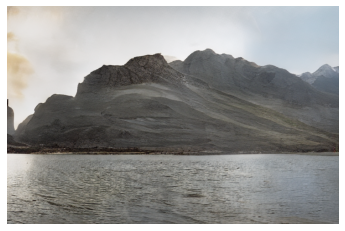